# Ensemble Learning

## Initial Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.preprocessing import StandardScaler

## Read the CSV and Perform Basic Data Cleaning

In [4]:
# Load the data
file_path = Path('Resources/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path)

# Preview the data
df.tail(5)

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
68812,10000.0,0.1502,346.76,RENT,26000.0,Source Verified,Jan-2019,low_risk,n,9.60,...,80.0,0.0,0.0,0.0,20625.0,6798.0,11300.0,5425.0,N,N
68813,12000.0,0.2727,368.37,RENT,63000.0,Not Verified,Jan-2019,low_risk,n,29.07,...,96.2,0.0,0.0,0.0,87939.0,60350.0,13500.0,62939.0,N,N
68814,5000.0,0.1992,185.62,MORTGAGE,52000.0,Source Verified,Jan-2019,low_risk,n,14.86,...,100.0,0.0,1.0,0.0,30592.0,18611.0,3600.0,18492.0,N,N
68815,40000.0,0.0646,1225.24,MORTGAGE,520000.0,Verified,Jan-2019,low_risk,n,9.96,...,98.2,12.5,0.0,0.0,1033574.0,95958.0,100800.0,78634.0,N,N
68816,16000.0,0.1131,350.36,MORTGAGE,72000.0,Verified,Jan-2019,low_risk,n,7.02,...,94.3,0.0,1.0,0.0,251486.0,74835.0,23000.0,63090.0,N,N


## Split the Data into Training and Testing

In [5]:
# Create our features
X = df.copy()
X.drop("loan_status", axis=1, inplace=True)
X.head()

# Create our target
y = df["loan_status"].values.reshape(-1, 1)
y[:5]

array([['low_risk'],
       ['low_risk'],
       ['low_risk'],
       ['low_risk'],
       ['low_risk']], dtype=object)

In [6]:
X.describe()


,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,6.881700e+04,6.881700e+04,68817.000000,6.881700e+04
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.052138,2.219423,95.057627,30.626217,0.125972,0.0,2.100332e+05,6.133843e+04,29734.128558,5.572240e+04
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.390633,1.897432,8.326426,33.631463,0.336732,0.0,1.928088e+05,5.738798e+04,26795.394232,5.095845e+04
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,20.000000,0.000000,0.000000,0.0,3.600000e+03,2.350000e+02,100.000000,1.270000e+02
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.000000,93.000000,0.000000,0.000000,0.0,6.697700e+04,2.650300e+04,11600.000000,2.288000e+04
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,2.000000,100.000000,20.000000,0.000000,0.0,1.467100e+05,4.535700e+04,22100.000000,4.200000e+04
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,3.000000,100.000000,50.000000,0.000000,0.0,3.036400e+05,7.657000e+04,39300.000000,7.249900e+04
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,18.000000,19.000000,100.000000,100.000000,4.000000,0.0,3.292782e+06,1.295455e+06,509400.000000,1.426964e+06


In [7]:
# Check the balance of our target values

X.shape

(68817, 85)

In [8]:
X.head()

#Option 1 = X.drop([['home_ownership',]], axis = 1)


#Option 2 = dummy values for home ownership, verification status, payment plan and issue_date
X = pd.get_dummies(X)

In [9]:
# Split the X and y into X_train, X_test, y_train, y_test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)

## Data Pre-Processing

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, you only scale the features data (`X_train` and `X_testing`).

In [10]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [11]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
X_scaler = scaler.fit(X_train)

In [12]:
# Scale the training and testing data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Display the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier only, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [13]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

brf = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
brf.fit(X_train, y_train)
y_pred_rf = brf.predict(X_test)

In [14]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred_rf)

0.7877672625306695

In [15]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred_rf)

array([[   58,    29],
       [ 1560, 15558]], dtype=int64)

In [16]:
# Print the imbalanced classification report
y_pred_rf = brf.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred_rf))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.04      0.67      0.91      0.07      0.78      0.59        87
   low_risk       1.00      0.91      0.67      0.95      0.78      0.62     17118

avg / total       0.99      0.91      0.67      0.95      0.78      0.62     17205



In [17]:
# List the features sorted in descending order by feature importance
importances = brf.feature_importances_
#
# Sort the feature importance in descending order
#
sorted_indices = np.argsort(importances)[::-1]
sorted_indices



array([15, 16, 14, 13, 20,  1, 11,  4, 35, 84,  2,  3, 44, 53, 74, 12, 42,
       85,  9, 48, 73, 25, 47, 31, 43, 32, 72, 36, 75, 61, 37, 52, 68, 10,
       30, 49, 62,  0, 40, 58, 60, 50, 55, 39, 69, 63, 56,  7, 41, 38, 59,
       29, 57, 27, 34, 51, 17, 67, 26, 89, 33, 28, 83, 90,  6,  5, 54, 24,
       78, 77, 81, 82, 80, 79, 70,  8, 87, 91, 66, 88, 92, 21, 76, 65, 64,
       93, 19, 18, 86, 45, 23, 22, 71, 46, 94], dtype=int64)

In [18]:
importances_sorted = sorted(zip(brf.feature_importances_, X.columns), reverse=True)
importances_sorted[:10]

[(0.07376667607601396, 'total_rec_prncp'),
 (0.06390324452717588, 'total_rec_int'),
 (0.06073336071656837, 'total_pymnt_inv'),
 (0.05811195697921674, 'total_pymnt'),
 (0.04951778391272079, 'last_pymnt_amnt'),
 (0.02458051789018817, 'int_rate'),
 (0.020398879691407974, 'out_prncp'),
 (0.018625883307901298, 'dti'),
 (0.018378884967316288, 'max_bal_bc'),
 (0.017480030880564042, 'issue_d_Jan-2019')]


Bad key text.latex.preview in file C:\Users\arkie\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.0/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\arkie\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.0/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\arkie\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, 

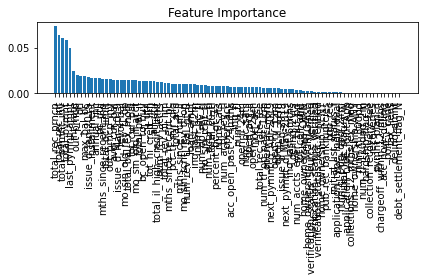

In [19]:
import matplotlib.pyplot as plt
 
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

### Easy Ensemble Classifier

In [20]:
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imblearn.ensemble import EasyEnsembleClassifier 

# Train the Classifier
brf = EasyEnsembleClassifier(n_estimators=100, random_state=1)
brf.fit(X_train, y_train)
y_pred_rf2 = brf.predict(X_test)

In [21]:
# Calculated the balanced accuracy score

from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred_rf2)

0.925427358175101

In [22]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred_rf2)

array([[   79,     8],
       [  979, 16139]], dtype=int64)

In [23]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred_rf2))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.07      0.91      0.94      0.14      0.93      0.85        87
   low_risk       1.00      0.94      0.91      0.97      0.93      0.86     17118

avg / total       0.99      0.94      0.91      0.97      0.93      0.86     17205



### Final Questions

1. Which model had the best balanced accuracy score?

   Balanced Forest Random Classifier = 0.7877672625306695
   Easy Ensemble Classifier = 0.925427358175101
   
   Easy ensemble classifier resulted in the best balanced accuracy score

2. Which model had the best recall score?

    The best average recall belonged to the easy ensemble classifier at 0.94 vs 0.91 in balanced forest random classifier

3. Which model had the best geometric mean score?

    Easy Ensemble Classifier at 0.91 had the best geometric mean store, compared to 0.78 for balacned forest random classifier

4. What are the top three features?

 [(0.07376667607601396, 'total_rec_prncp'),
 (0.06390324452717588, 'total_rec_int'),
 (0.06073336071656837, 'total_pymnt_inv'),
